# Implementation of Softmax Regression from Scratch
:label:`sec_softmax_scratch`

Just as we implemented linear regression from scratch,
we believe that multiclass logistic (softmax) regression
is similarly fundamental and you ought to know
the gory details of how to implement it yourself.
As with linear regression, after doing things by hand
we will breeze through an implementation in DJL for comparison.
To begin, let us import the familiar packages.

In [1]:
%use @file[../djl.json]
%use lets-plot
@file:DependsOn("../D2J-1.0-SNAPSHOT.jar")
//import jp.live.ugai.d2j.attention.Chap10Utils
import jp.live.ugai.d2j.util.Training
import jp.live.ugai.d2j.util.ImageUtils
import jp.live.ugai.d2j.util.Accumulator
// %load ../utils/plot-utils.ipynb
// %load ../utils/Training.java
// %load ../utils/FashionMnistUtils.java
// %load ../utils/ImageUtils.java
import ai.djl.basicdataset.cv.classification.FashionMnist
import ai.djl.metric.Metrics

fun getLong(nm: String, n: Long): Long {
    val name = System.getProperty(nm)
    return if (null == name) n.toLong() else name.toLong()
}

In [2]:
import ai.djl.ndarray.NDArray;
import ai.djl.ndarray.NDManager;
import ai.djl.training.dataset.ArrayDataset;
import ai.djl.training.dataset.Record;

import java.awt.Color;
import java.awt.Graphics2D;
import java.awt.image.BufferedImage;

object FashionMnistUtils {

    fun getFashionMnistLabels(labelIndices: IntArray) : Array<String>{
        val textLabels = arrayOf(
            "t-shirt",
            "trouser",
            "pullover",
            "dress",
            "coat",
            "sandal",
            "shirt",
            "sneaker",
            "bag",
            "ankle boot"
        )
        val convertedLabels = arrayOf<String>()
        for (i in 0.. labelIndices.size-1) {
            convertedLabels[i] = textLabels[labelIndices[i]];
        }
        return convertedLabels;
    }

    fun getFashionMnistLabel(labelIndice: Int) : String{
        val textLabels = arrayOf(
            "t-shirt",
            "trouser",
            "pullover",
            "dress",
            "coat",
            "sandal",
            "shirt",
            "sneaker",
            "bag",
            "ankle boot"
        )
        return textLabels[labelIndice]
    }

    fun showImages(
            dataset: ArrayDataset , number: Int, width: Int, height: Int,scale: Int,manager: NDManager): BufferedImage {
        val images = mutableListOf<BufferedImage>()
        val labels = mutableListOf<String>()
        for (i in 0 until number) {
            val record = dataset.get(manager, i.toLong());
            val array = record.getData().get(0).squeeze(-1);
            val y = record.getLabels().get(0).getFloat().toInt()
            images.add(toImage(array, width, height))
            labels.add(getFashionMnistLabel(y))
        }
        val w = images.first().getWidth() * scale;
        val h = images.first().getHeight() * scale;

        return ImageUtils.showImages(images, labels, w, h);
    }

    fun showImages(
            dataset: ArrayDataset ,
            predLabels: IntArray,
            width: Int,
            height: Int,
            scale: Int,
            manager: NDManager ) : BufferedImage{
        val number = predLabels.size
        val images = mutableListOf<BufferedImage>()
        val labels = mutableListOf<String>()
        for (i in 0.. number-1) {
            val record = dataset.get(manager, i.toLong());
            val array = record.getData().get(0).squeeze(-1);
            images.add(toImage(array, width, height))
            labels.add(getFashionMnistLabel(predLabels[i]))
        }
        val w = images.first().getWidth() * scale;
        val h = images.first().getHeight() * scale;

        return ImageUtils.showImages(images, labels, w, h);
    }

    fun toImage(array: NDArray,width: Int,height: Int) : BufferedImage{
        System.setProperty("apple.awt.UIElement", "true");
        val img = BufferedImage(width, height, BufferedImage.TYPE_BYTE_GRAY);
        val g = img.getGraphics();
        for (i in 0 .. width-1) {
            for (j in 0 .. height-1) {
                val c = array.getFloat(j.toLong(), i.toLong()) / 255; // scale down to between 0 and 1
                g.setColor(Color(c, c, c)); // set as a gray color
                g.fillRect(i, j, 1, 1);
            }
        }
        g.dispose();
        return img;
    }
}


We will work with the Fashion-MNIST dataset, just introduced in :numref:`sec_fashion_mnist`,
setting up an iterator with batch size $256$. We also set it to randomly shuffled elements for each batch for the training set. 

In [3]:
val batchSize = 256
val randomShuffle = true

// get training and validation dataset
val trainingSet = FashionMnist.builder()
        .optUsage(Dataset.Usage.TRAIN)
        .setSampling(batchSize, randomShuffle)
        .optLimit(getLong("DATASET_LIMIT", Long.MAX_VALUE))
        .build()

val validationSet = FashionMnist.builder()
        .optUsage(Dataset.Usage.TEST)
        .setSampling(batchSize, false)
        .optLimit(getLong("DATASET_LIMIT", Long.MAX_VALUE))
        .build()

## Initializing Model Parameters

As in our linear regression example,
each example here will be represented by a fixed-length vector.
Each example in the raw data is a $28 \times 28$ image.
In this section, we will flatten each image,
treating them as $784$-long 1D vectors.
In the future, we will talk about more sophisticated strategies
for exploiting the spatial structure in images,
but for now we treat each pixel location as just another feature.

Recall that in softmax regression,
we have as many outputs as there are categories.
Because our dataset has $10$ categories,
our network will have an output dimension of $10$.
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ vector.
As with linear regression, we will initialize our weights $W$
with Gaussian noise and our biases to take the initial value $0$.

In [4]:
val numInputs = 784L
val numOutputs = 10L

val manager = NDManager.newBaseManager()
val W = manager.randomNormal(0f, 0.01f, Shape(numInputs, numOutputs), DataType.FLOAT32);
val b = manager.zeros(Shape(numOutputs), DataType.FLOAT32);
val params = NDList(W, b)
    // Attach Gradients
for (param in params) {
    param.setRequiresGradient(true)
}
    


## The Softmax

Before implementing the softmax regression model,
let us briefly review how operators such as `sum()` work
along specific dimensions in an `NDArray`.
Given a matrix `X` we can sum over all elements (default) or only
over elements in the same axis, *i.e.*, the column (`new int[]{0}`) or the same row (`new int[]{1}`).
We wrap the axis in an int array since we can specify multiple axes as well.
For example if we call `sum()` with `new int[]{0, 1}`, it sums up the elements over both the rows and columns.
In this 2D array, this means the total sum of the elements within! 
Note that if `X` is an array with shape `($2$, $3$)`
and we sum over the columns (`X.sum(new int[]{0})`),
the result will be a (1D) vector with shape `($3$,)`.
If we want to keep the number of axes in the original array
(resulting in a 2D array with shape `($1$, $3$)`),
rather than collapsing out the dimension that we summed over
we can specify `true` when invoking `sum()`.

In [5]:
val X = manager.create(arrayOf(intArrayOf(1, 2, 3), intArrayOf(4, 5, 6)))
println(X)
println(X.sum(intArrayOf(0), true))
println(X.sum(intArrayOf(1), true))
println(X.sum(intArrayOf(0, 1), true))

ND: (2, 3) cpu() int32
[[ 1,  2,  3],
 [ 4,  5,  6],
]

ND: (1, 3) cpu() int32
[[ 5,  7,  9],
]

ND: (2, 1) cpu() int32
[[ 6],
 [15],
]

ND: (1, 1) cpu() int32
[[21],
]



We are now ready to implement the softmax function.
Recall that softmax consists of two steps:
First, we exponentiate each term (using `exp()`).
Then, we sum over each row (we have one row per example in the batch)
to get the normalization constants for each example.
Finally, we divide each row by its normalization constant,
ensuring that the result sums to $1$.
Before looking at the code, let us recall
how this looks expressed as an equation:

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}.
$$

The denominator, or normalization constant,
is also sometimes called the partition function
(and its logarithm is called the log-partition function).
The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
where a related equation models the distribution
over an ensemble of particles.

In [6]:
fun softmax(X: NDArray): NDArray  {
    val Xexp = X.exp()
    val partition = Xexp.sum(intArrayOf(1), true)
    return Xexp.div(partition) // The broadcast mechanism is applied here
}

As you can see, for any random input,
we turn each element into a non-negative number.
Moreover, each row sums up to 1,
as is required for a probability.
Note that while this looks correct mathematically,
we were a bit sloppy in our implementation
because we failed to take precautions against numerical overflow or underflow
due to large (or very small) elements of the matrix,
as we did in :numref:`sec_naive_bayes`.

In [7]:
val X = manager.randomNormal(Shape(2, 5))
val Xprob = softmax(X)
println(Xprob)
println(Xprob.sum(intArrayOf(1)))

ND: (2, 5) cpu() float32
[[0.4817, 0.1687, 0.1143, 0.0855, 0.1497],
 [0.106 , 0.2568, 0.0916, 0.5211, 0.0244],
]

ND: (2) cpu() float32
[1., 1.]



## The Model

Now that we have defined the softmax operation,
we can implement the softmax regression model.
The below code defines the forward pass through the network.
Note that we flatten each original image in the batch
into a vector with length `numInputs` with the `reshape()` function
before passing the data through our model.

In [8]:
fun net(X: NDArray) : NDArray {
        val currentW = params.get(0);
        val currentB = params.get(1);
        return softmax(X.reshape(Shape(-1, numInputs)).dot(currentW).add(currentB))
}

## The Loss Function

Next, we need to implement the cross-entropy loss function,
introduced in :numref:`sec_softmax`.
This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.

Recall that cross-entropy takes the negative log likelihood
of the predicted probability assigned to the true label $-\log P(y \mid x)$.
Rather than iterating over the predictions with a Java `for` loop
(which tends to be inefficient),
we can use the NDArray `get()` function in conjunction with `NDIndex`
to let us easily select the appropriate terms
from the matrix of softmax entries. This is typically known as the `pick()`
operator in other frameworks such as `PyTorch`.
Below, we illustrate the usage on a toy example,
with $3$ categories and $2$ examples.

The `":, {}"` section of the `NDIndex` selects all arrays
and the `manager.create(new int[]{0, 2})` creates an
`NDArray` with the values 0 and 2 to pick the 0th and 2nd elements
for each respective `NDArray`.

Note: when using `NDIndex` in this way, the passed in `NDArray` used for picking
indices must be of type `int` or `long`. You can use the `toType()` function
to change the type of the `NDArray` which will be shown below.

In [76]:
val yHat = manager.create(arrayOf(floatArrayOf(0.1f, 0.3f, 0.6f), floatArrayOf(0.3f, 0.2f, 0.5f))).reshape(1,2,3)
//yHat.get(new NDIndex(":, {}", manager.create(new int[]{0, 2})));
//yHat.get(NDIndex(":, {}", manager.create(intArrayOf(0,2))))
//val x = NDIndex(":,  {}", manager.create(intArrayOf(0,2)))
//val x = NDIndex().addAllDim(Math.floorMod(-1, yHat.getShape().dimension())).addPickDim(y)
val x = NDIndex().addAllDim().addPickDim(manager.create(intArrayOf(0,2)))
//println(yHat.getShape())
println(yHat.getShape().dimension())
//println(Math.floorMod(-1, 4))
println(yHat.reshape(1,2,3))
//println(y)
//val y = NDIndex(":, 0,2")
//println(yHat.get(":, 0:2"))
yHat.get(0).get(x)
//manager.create(intArrayOf(0,2))
//yHat.get(NDIndex(":, {}", longArrayOf(0,2)))

3
ND: (1, 2, 3) cpu() float32
[[[0.1, 0.3, 0.6],
  [0.3, 0.2, 0.5],
 ],
]



ND: (2, 1) cpu() float32
[[0.1],
 [0.5],
]


Now we can implement the cross-entropy loss function efficiently with just one line of code.

In [10]:
// Cross Entropy only cares about the target class's probability
// Get the column index for each row
fun crossEntropy(yHat: NDArray, y: NDArray) : NDArray {
        // Here, y is not guranteed to be of datatype int or long
        // and in our case we know its a float32.
        // We must first convert it to int or long(here we choose int)
        // before we can use it with NDIndex to "pick" indices. 
        // It also takes in a boolean for returning a copy of the existing NDArray
        // but we don't want that so we pass in `false`.
//        return yHat.get(NDIndex(":, {}", y.toType(DataType.INT32, false))).log().neg()
        val pickIndex = NDIndex()
            .addAllDim(Math.floorMod(-1, yHat.getShape().dimension()))
//            .addPickDim(y.toType(DataType.INT32, false))
            .addPickDim(y)
        return yHat.get(pickIndex).log().neg()

}


## Classification Accuracy

Given the predicted probability distribution `yHat`,
we typically choose the class with highest predicted probability
whenever we must output a *hard* prediction.
Indeed, many applications require that we make a choice.
Gmail must categorize an email into Primary, Social, Updates, or Forums.
It might estimate probabilities internally,
but at the end of the day it has to choose one among the categories.

When predictions are consistent with the actual category `y`, they are correct.
The classification accuracy is the fraction of all predictions that are correct.
Although it can be difficult optimize accuracy directly (it is not differentiable),
it is often the performance metric that we care most about,
and we will nearly always report it when training classifiers.

To compute accuracy we do the following:
First, we execute `yHat.argMax(1)` where 1 is the axis
to gather the predicted classes
(given by the indices for the largest entries in each row).
The result has the same shape as the variable `y`.
Now we just need to check how frequently the two match.
Since the equality function `eq()` is datatype-sensitive
(e.g., a `float32` and a `float32` are never equal),
we also need to convert both to the same type (we pick `int32`).
The result is an `NDArray` containing entries of 0 (false) and 1 (true).
We then sum the number of true entries and convert the result to a float.
Finally, we get the mean by dividing by the number of data points.

In [11]:
// Saved in the utils for later use
fun accuracy(yHat: NDArray, y: NDArray) : Float {
    // Check size of 1st dimension greater than 1
    // to see if we have multiple samples
    if (yHat.getShape().size(1) > 1) {
        // Argmax gets index of maximum args for given axis 1
        // Convert yHat to same dataType as y (int32)
        // Sum up number of true entries
        return yHat.argMax(1).toType(DataType.INT32, false).eq(y.toType(DataType.INT32, false))
            .sum().toType(DataType.FLOAT32, false).getFloat()
    }
    return yHat.toType(DataType.INT32, false).eq(y.toType(DataType.INT32, false))
        .sum().toType(DataType.FLOAT32, false).getFloat()
}

We will continue to use the variables `yHat` and `y`
defined in the `pick()` function,
as the predicted probability distribution and label, respectively.
We can see that the first example's prediction category is $2$
(the largest element of the row is $0.6$ with an index of $2$),
which is inconsistent with the actual label, $0$.
The second example's prediction category is $2$
(the largest element of the row is $0.5$ with an index of $2$),
which is consistent with the actual label, $2$.
Therefore, the classification accuracy rate for these two examples is $0.5$.

In [12]:
val y = manager.create(intArrayOf(0,2))
accuracy(yHat, y) / y.size()

0.5

Similarly, we can evaluate the accuracy for model `net` on the dataset
(accessed via `dataIterator`).

In [13]:
// Saved in the utils for future use
fun evaluateAccuracy( net: (NDArray) -> NDArray,  dataIterator: Iterable<Batch>) : Float{
    val metric = Accumulator(2)  // numCorrectedExamples, numExamples
    val batch = dataIterator.iterator().next();
    val X = batch.getData().head();
    val y = batch.getLabels().head();
    metric.add(floatArrayOf(accuracy(net(X), y), y.size().toFloat()))
    batch.close()

    return metric.get(0) / metric.get(1);
}

Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing,
i.e., $0.1$ for $10$ classes.

In [14]:
evaluateAccuracy(::net, validationSet.getData(manager))

0.11328125

## Model Training

The training loop for softmax regression should look strikingly familiar
if you read through our implementation
of linear regression in :numref:`sec_linear_scratch`.
Here we refactor the implementation to make it reusable.
First, we define a function to train for one data epoch.
Note that `updater()` is a general function to update the model parameters,
which accepts the batch size as an argument.
Currently, it is a wrapper of `Training.sgd()`.

In [15]:
val lr = 0.1f

fun trainEpochCh3(net: (NDArray)->NDArray ,
                  trainIter: Iterable<Batch> ,
                  loss: (NDArray, NDArray)->NDArray , updater: (NDList, Float, Int)->Unit ) : FloatArray {
    val metric = Accumulator(3); // trainLossSum, trainAccSum, numExamples
    
    for (batch in trainIter) {
        var X = batch.getData().head();
        val y = batch.getLabels().head();
        X = X.reshape(Shape(-1, numInputs));
            
        val gc = Engine.getInstance().newGradientCollector()
            // Minibatch loss in X and y
           val yHat = net(X);
            val l = loss(yHat, y)
            gc.backward(l);  // Compute gradient on l with respect to w and b
            metric.add(floatArrayOf(l.sum().toType(DataType.FLOAT32, false).getFloat(), 
                                   accuracy(yHat, y), 
                                   y.size().toFloat()))
        gc.close()
        updater(params, lr, batch.getSize());  // Update parameters using their gradient
        batch.close();
    }
    // Return trainLoss, trainAccuracy
    return floatArrayOf(metric.get(0) / metric.get(2), metric.get(1) / metric.get(2))
}

Before showing the implementation of the training function, we define a utility class that draws data in animation. Again, it aims to simplify the code in later chapters.

In [16]:
import org.jetbrains.letsPlot.*
import org.jetbrains.letsPlot.intern.Plot

// Saved in utils
/* Animates a graph with real-time data. */
class Animator {
    val epochs = mutableListOf<Int>()
    val values = mutableListOf<Float>()
    val metrics = mutableListOf<String>()      
    // Add a single metric to the table
   fun add(epoch: Int, value: Float, metric: String) {
       epochs.add(epoch)
       values.add(value)
       metrics.add(metric)
       
    }
    
    // Add accuracy, train accuracy, and train loss metrics for a given epoch
    // Then plot it on the graph
    fun add(epoch : Int, accuracy: Float, trainAcc: Float, trainLoss: Float) {
        add(epoch, trainLoss, "train loss");
        add(epoch, trainAcc, "train accuracy");
        add(epoch, accuracy, "test accuracy");
    }
    
    // Display the graph
    fun show() : Plot {
        val data = mapOf("epoch" to epochs, "value" to values, "metric" to metrics)
        // updateDisplay(id, LinePlot.create("", data, "epoch", "value", "metric"));
//        println(data)
        var plot = letsPlot(data)
        plot += geomLine { x = "epoch" ; y = "value" ; color = "metric"}
        return plot + ggsize(500, 500)
    }
}

The training function then runs multiple epochs and visualize the training progress.

In [17]:
fun trainCh3(net: (NDArray)->NDArray , trainDataset: Dataset , testDataset:Dataset , 
                     loss: (NDArray, NDArray)->NDArray , numEpochs: Int, updater: (NDList, Float, Int)->Unit ) 
     : Plot {
    val animator = Animator()
    for (i in 1..numEpochs) {
        val trainMetrics = trainEpochCh3(net, trainDataset.getData(manager), loss, updater)
        val accuracy = evaluateAccuracy(net, testDataset.getData(manager));
        val trainAccuracy = trainMetrics[1];
        val trainLoss = trainMetrics[0];
        
        animator.add(i, accuracy, trainAccuracy, trainLoss)
        println("Epoch %d: Test Accuracy: %f".format(i, accuracy))
        println("Train Accuracy: %f".format(trainAccuracy))
        println("Train Loss: %f".format(trainLoss))
    }
    return animator.show()
}

Again, we use the minibatch stochastic gradient descent
to optimize the loss function of the model.
Note that the number of epochs (`numEpochs`),
and learning rate (`lr`) are both adjustable hyper-parameters.
By changing their values, we may be able
to increase the classification accuracy of the model.
In practice we will want to split our data three ways
into training, validation, and test data,
using the validation data to choose
the best values of our hyper-parameters.

In [18]:
val numEpochs = 5;
val lr = 0.01f;

fun updater(params:NDList , lr: Float, batchSize: Int) {
        for (param in params) {
            param.subi(param.getGradient().mul(lr).div(batchSize));
        }
}

trainCh3(::net, trainingSet, validationSet, ::crossEntropy, numEpochs, ::updater);

Epoch 1: Test Accuracy: 0.750000
Train Accuracy: 0.746950
Train Loss: 0.786403
Epoch 2: Test Accuracy: 0.812500
Train Accuracy: 0.812350
Train Loss: 0.571506
Epoch 3: Test Accuracy: 0.828125
Train Accuracy: 0.825617
Train Loss: 0.525999
Epoch 4: Test Accuracy: 0.847656
Train Accuracy: 0.832233
Train Loss: 0.501169
Epoch 5: Test Accuracy: 0.835938
Train Accuracy: 0.836683
Train Loss: 0.485659


## Prediction

Now that training is complete,
our model is ready to classify some images.
Given a series of images,
we will compare their actual labels
(first line of text output)
and the model predictions
(second line of text output).


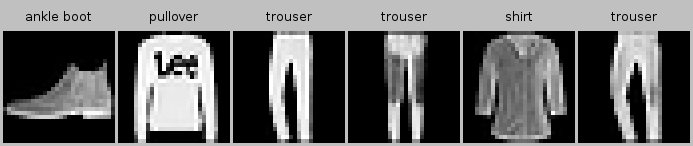

In [19]:
import java.awt.image.BufferedImage
// Saved in the FashionMnistUtils class for later use
// Number should be < batchSize for this function to work properly
fun  predictCh3(net: (NDArray)->NDArray , dataset: ArrayDataset , number: Int, manager: NDManager ) : BufferedImage {
    val predLabels = IntArray(number)
    
    val batch = dataset.getData(manager).iterator().next()
    val X = batch.getData().head()
    val yHat = net(X).argMax(1).toType(DataType.INT32, false).toIntArray()
    for (i in 0..number-1) {
        predLabels[i] = yHat[i]
    }
    
    return FashionMnistUtils.showImages(dataset, predLabels, 28, 28, 4, manager)
}

predictCh3(::net, validationSet, 6, manager)

## Summary

With softmax regression, we can train models for multi-category classification.
The training loop is very similar to that in linear regression:
retrieve and read data, define models and loss functions,
then train models using optimization algorithms.
As you will soon find out, most common deep learning models
have similar training procedures.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. What problems might this cause (hint: try to calculate the size of $\exp(50)$)?
1. The function `crossEntropy()` in this section is implemented according to the definition of the cross-entropy loss function.  What could be the problem with this implementation (hint: consider the domain of the logarithm)?
1. What solutions you can think of to fix the two problems above?
1. Is it always a good idea to return the most likely label. E.g., would you do this for medical diagnosis?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?